Behavioral Cloning Project - Driving Simulator

In [1]:
import csv
import cv2
import numpy as np
from tqdm import tqdm   #Library for progress bar on for loops.

#Read in the csv file.
lines = []
with open('../data/driving_log.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(csvfile)                       #Skip the header
    for line in reader:
        lines.append(line)

correction = 0.2  #Hyperparameter to tune
        
#Filling X_train and y_train        
images = []
measurements = []
for line in tqdm(lines):
    #Center camera
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = '../data/IMG/' + filename
    image = cv2.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)    
    
    #Left camera
    source_path = line[1]
    filename = source_path.split('/')[-1]
    current_path = '../data/IMG/' + filename
    image = cv2.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement + correction)
    
    #Right camera
    source_path = line[2]
    filename = source_path.split('/')[-1]
    current_path = '../data/IMG/' + filename
    image = cv2.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement - correction)


print(len(images))
print(len(measurements))
print(np.count_nonzero(np.array(measurements))) #This is a measure of the quality of the training data. The higher the better.

100%|██████████| 8036/8036 [00:48<00:00, 166.82it/s]

24108
24108
19747


In [2]:
from cv2 import resize
resized_images = []
for image in tqdm(images):
    resized_images.append(cv2.resize(image,dsize=(64,64)))

print(len(resized_images))

100%|██████████| 24108/24108 [00:06<00:00, 3519.40it/s]

24108


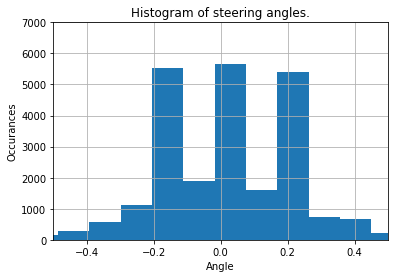

In [3]:
#Histogram of steering angles.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# the histogram of the data
n, bins, patches = plt.hist(measurements, 25)

plt.xlabel('Angle')
plt.ylabel('Occurances')
plt.title('Histogram of steering angles.')
plt.axis([-.5, .5, 0, 7000])
plt.grid(True)

plt.show()
#Much more lefthand turning.

In [4]:
augmented_images, augmented_measurements = [], []
for image, measurement in zip(resized_images,measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement*-1.0)

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)
print(X_train.shape)
print(y_train.shape)

(48216, 64, 64, 3)
(48216,)


This image is: <class 'numpy.ndarray'> with dimensions: (64, 64, 3)
Steering angle:  0.0787459


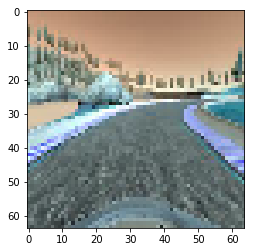

In [5]:
#Plotting an image and its flipped counterpart w/steering angles.
#image_number = 9900 #Good image for MY data.
image_number = 4549 #Good image for UDACITY data.

#printing out some stats and plotting
print('This image is:', type(X_train[image_number]), 'with dimensions:', X_train[image_number].shape)
print('Steering angle: ',y_train[image_number])
plt.imshow(X_train[image_number])

Steering angle:  0.1212541


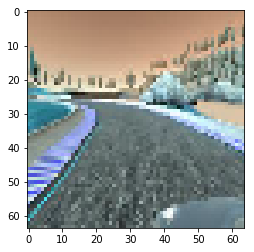

In [6]:
#Flipped image
plt.imshow(X_train[image_number+1])
print('Steering angle: ',y_train[image_number+1])


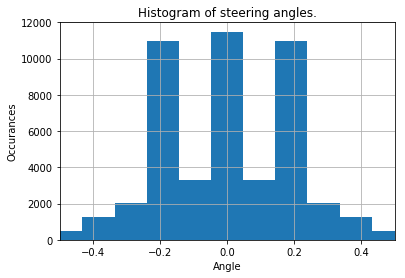

In [7]:
#Histogram of steering angles.

# the histogram of the data
n, bins, patches = plt.hist(y_train, 25)

plt.xlabel('Angle')
plt.ylabel('Occurances')
plt.title('Histogram of steering angles.')
plt.axis([-.5, .5, 0, 12000])
plt.grid(True)

plt.show()
#Much better-looking distribution.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Lambda
from keras.layers import Cropping2D
from keras.layers import Convolution2D, MaxPooling2D, Activation, Dropout, ZeroPadding2D
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(64,64,3)))
model.add(Cropping2D(cropping=((25,10), (0,0))))
model.add(ZeroPadding2D(padding=(2, 2)))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
#model.add(ZeroPadding2D(padding=(1, 1)))
#model.add(Convolution2D(64,3,3,activation='relu'))

model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

#Use if continuing training from a previous checkpoint.
#model.load_weights("../model_behavioral_cloning_7_1-00.h5")

model.compile(loss ='mse', optimizer='adam')

filepath="../model_behavioral_cloning_9_2_1-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
callbacks_list = [checkpoint]

history_object = model.fit(X_train,y_train,validation_split=0.2,shuffle=True, nb_epoch=4,batch_size=512,callbacks=callbacks_list)

Using TensorFlow backend.


Train on 38572 samples, validate on 9644 samples
Epoch 1/5
38572/38572 [==============================] - 124s - loss: 0.0208 - val_loss: 0.0180
Epoch 2/5
38572/38572 [==============================] - 111s - loss: 0.0148 - val_loss: 0.0178
Epoch 3/5
38572/38572 [==============================] - 102s - loss: 0.0127 - val_loss: 0.0195
Epoch 4/5
38572/38572 [==============================] - 117s - loss: 0.0117 - val_loss: 0.0198
Epoch 5/5
38572/38572 [==============================] - 89s - loss: 0.0107 - val_loss: 0.0208


dict_keys(['loss', 'val_loss'])


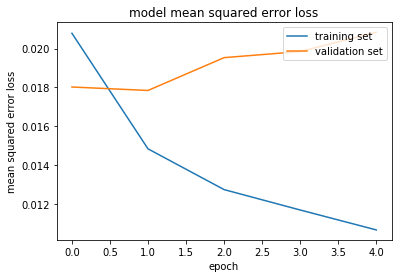

In [9]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()